In [61]:
!pip install -u scipy==1.2.0
!pip install -u numpy==1.19.5


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [62]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
import numpy as np
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [63]:
def viewImage(path):
  img=load_img(path)

  # Display the loaded image
  plt.imshow(img)
  plt.show()

  # Convert the image to a NumPy array
  img_array = img_to_array(img)
  print("Shape of the image array:", img_array.shape)

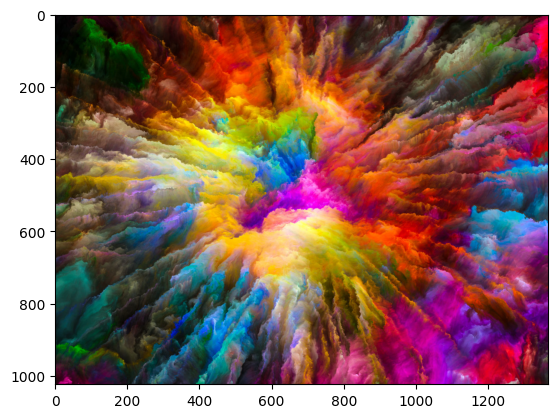

Shape of the image array: (1024, 1365, 3)


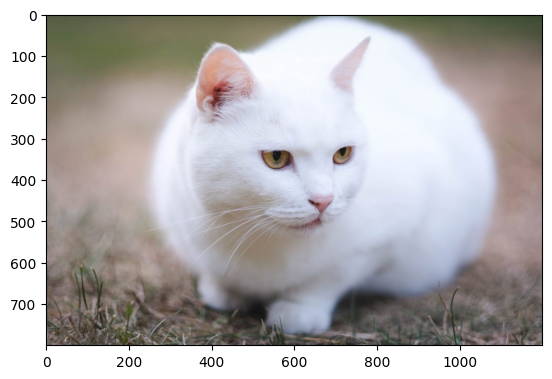

Shape of the image array: (800, 1200, 3)


In [64]:
content_image_path="content1.jpg"
style_image_path="style1.jpg"
viewImage(style_image_path)
viewImage(content_image_path)


In [65]:
width, height=load_img(content_image_path).size
img_h=400
img_w=int(width*img_h/height)
print("Height = ",height,"\nWidth = ",width,"\nImg_height = ",img_h,"\nImg_width = ",img_w)

Height =  800 
Width =  1200 
Img_height =  400 
Img_width =  600


In [66]:
def preprocess(path):
  img=load_img(path,target_size=(img_h,img_w))
  img=img_to_array(img)
  img=np.expand_dims(img,axis=0)
  img=vgg19.preprocess_input(img)
  return img

In [80]:
def deprocess(img):
  img[:,:,0]+=103.939
  img[:,:,1]+=116.779
  img[:,:,2]+=123.68
  #bgr -> rgb
  img=img[:,:,::-1]
  img=np.clip(img,0,255).astype('uint8')
  return img;

In [68]:
content_image=K.constant(preprocess(content_image_path))
style_image=K.constant(preprocess(style_image_path))

combination_image=K.placeholder((1,img_h,img_w,3))

input_tensor=K.concatenate([content_image,style_image,combination_image],axis=0)

model=vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)

print("Model loaded")

Model loaded


In [69]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

In [70]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [71]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_h*img_w
    return K.sum(K.square(S-C))/(4.*(channels**2) * (size**2))

In [72]:
def total_variation_loss(x):
    a = K.square(x[:,:img_h-1,:img_w-1,:] - x[:,1:, :img_w-1, :])
    b = K.square(x[:,:img_h-1,:img_w-1,:] - x[:,:img_h-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))
  #it is used to avoid blurring
  #HOW?
  #we just the increase in pixels, which in fact avoids blurring effect

In [73]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 600, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 300, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 150, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_pool': <t

In [74]:
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1e-4

loss = K.variable(0.)

In [75]:
content_layer='block5_conv2'

style_layers=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_features=layers[content_layer]
target_image_features=layer_features[0,:,:,:]
combination_features =layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(target_image_features,combination_features)

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss+=total_variation_weight*total_variation_loss(combination_image)

In [76]:
grads=K.gradients(loss,combination_image)[0]

fetch_loss_ans_grads=K.function([combination_image],[loss,grads])

In [77]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_h, img_w, 3))
    outs = fetch_loss_ans_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [81]:
from scipy.optimize import fmin_l_bfgs_b
from matplotlib.pyplot import imsave
import time

res_prefix="result"

iterations = 5

x=preprocess(content_image_path)
x=x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img=x.copy().reshape((img_h,img_w,3))
    img=deprocess(img)
    fname=res_prefix+"_%d.png" % i
    imsave(fname,img)
    print("Image saved as",fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 4197494800.0
Image saved as result_0.png
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 1585338100.0
Image saved as result_1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 1018345540.0
Image saved as result_2.png
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 760054200.0
Image saved as result_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 630642050.0
Image saved as result_4.png
Iteration 4 completed in 9s


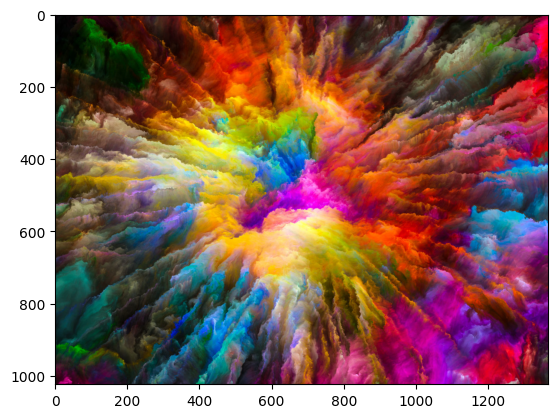

Shape of the image array: (1024, 1365, 3)


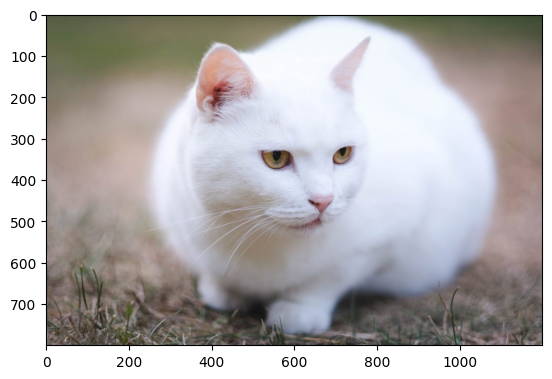

Shape of the image array: (800, 1200, 3)


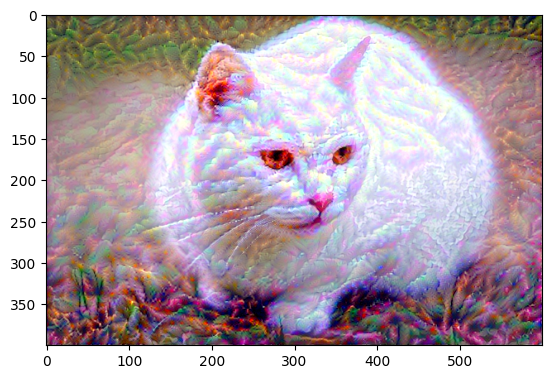

In [83]:
viewImage(style_image_path)
viewImage(content_image_path)

plt.imshow(img)
plt.show()